# Ensemble Learning

## Initial Imports

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [30]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.metrics import classification_report_imbalanced

## Read the CSV and Perform Basic Data Cleaning

In [31]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

print("Total NANs in the dataframe: ", df.isna().sum().sum(), "\n")

# Preview the data
df.head()

Total NANs in the dataframe:  0 



,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [32]:
# Checking logistic variables in select columns in the dataframe
print("Parsing for select columns for ones potentially having only one or a few constant values/descrete values: \n ")
print("home_ownership", set(df.home_ownership)) 
print("verification_status", set(df.verification_status)) 
print("issue_d", set(df.issue_d)) 
print("loan_status", set(df.loan_status))
print("pymnt_plan", set(df.pymnt_plan))
print("initial_list_status", set(df.initial_list_status))
print("next_pymnt_d", set(df.next_pymnt_d))
print("application_type", set(df.application_type))
print("hardship_flag", set(df.hardship_flag))
print("debt_settlement_flag", set(df.debt_settlement_flag))
print("tax_liens", set(df.tax_liens))
print("recoveries", set(df.recoveries))
print("policy_code", set(df.policy_code))
print("num_tl_30dpd", set(df.num_tl_30dpd))
print("num_tl_120dpd_2m", set(df.num_tl_120dpd_2m))
print("delinq_amnt", set(df.delinq_amnt))
print("collection_recovery_fee", set(df.collection_recovery_fee))
print("acc_now_delinq", set(df.acc_now_delinq))

Parsing for select columns for ones potentially having only one or a few constant values/descrete values: 
 
home_ownership {'OWN', 'MORTGAGE', 'RENT', 'ANY'}
verification_status {'Source Verified', 'Not Verified', 'Verified'}
issue_d {'Feb-2019', 'Jan-2019', 'Mar-2019'}
loan_status {'high_risk', 'low_risk'}
pymnt_plan {'n'}
initial_list_status {'f', 'w'}
next_pymnt_d {'May-2019', 'Apr-2019'}
application_type {'Individual', 'Joint App'}
hardship_flag {'N'}
debt_settlement_flag {'N'}
tax_liens {0.0}
recoveries {0.0}
policy_code {1.0}
num_tl_30dpd {0.0}
num_tl_120dpd_2m {0.0}
delinq_amnt {0.0, 18336.0, 16386.0, 357.0, 903.0, 65000.0, 17033.0, 5778.0, 84.0, 3094.0, 118.0, 32894.0, 1535.0}
collection_recovery_fee {0.0}
acc_now_delinq {0.0}


In [33]:
# Removing columns with the exact same value for all column values i.e. there cannot 
# be any dependence on the outcome (high_risk/low_lisk) as it could be considered as
# column with a constant value
df.drop(columns = ["pymnt_plan", 
                   "hardship_flag", 
                   "debt_settlement_flag",
                   "tax_liens",
                   "recoveries",
                   "policy_code",
                   "num_tl_30dpd",
                   "num_tl_120dpd_2m",
                   "collection_recovery_fee",
                   "acc_now_delinq"
                   ], inplace = True)
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,dti,delinq_2yrs,...,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,27.24,0.0,...,8.0,0.0,3.0,85.7,100.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,20.23,0.0,...,17.0,0.0,6.0,91.2,50.0,1.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,24.26,0.0,...,8.0,0.0,4.0,66.7,50.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,31.44,0.0,...,10.0,0.0,1.0,100.0,50.0,1.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,18.76,0.0,...,14.0,0.0,1.0,100.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0


In [34]:
# Rename select columns 
df.rename(
    columns = 
    {"home_ownership" : "h_o",
    "verification_status": "v_s",
    "issue_d": "i_d",
    "loan_status": "l_s",
    "initial_list_status": "i_l_s",
    "next_pymnt_d": "n_p_d",
    "application_type": "a_t"
    }, 
          inplace =True)
df.head()

,loan_amnt,int_rate,installment,h_o,annual_inc,v_s,i_d,l_s,dti,delinq_2yrs,...,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,27.24,0.0,...,8.0,0.0,3.0,85.7,100.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,20.23,0.0,...,17.0,0.0,6.0,91.2,50.0,1.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,24.26,0.0,...,8.0,0.0,4.0,66.7,50.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,31.44,0.0,...,10.0,0.0,1.0,100.0,50.0,1.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,18.76,0.0,...,14.0,0.0,1.0,100.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0


In [35]:
# Home ownership dictionary
home_ownership = {
    "ANY": 0,
    "OWN" : 1,
    "MORTGAGE": 2,
    "RENT": 3
}

# Verification status dictionary
verification_status = {
    "Not Verified": 0, 
    "Verified": 1,
    "Source Verified": 2
}

# Issue date dictionary
issue_d = {
    "Jan-2019": 0, 
    "Feb-2019": 1,
    "Mar-2019": 2
}

# Loan status dictionary
loan_status = {
    "high_risk": 0, 
    "low_risk": 1
}

# Initial list status dictionary
initial_list_status = {
    "w": 0, 
    "f": 1
}

# Next payment date dictionary
next_pymnt_d = {
    "Apr-2019": 0, 
    "May-2019": 1
}

# Application type dictionary
application_type = {
    "Joint App": 0, 
    "Individual": 1
}


# Home ownership encoded using the dictionary values
df["home_ownership"] = df["h_o"].apply(lambda x: home_ownership[x])

# Verification status encoded using the dictionary values
df["verification_status"] = df["v_s"].apply(lambda x: verification_status[x])

# Issue date encoded using the dictionary values
df["issue_d"] = df["i_d"].apply(lambda x: issue_d[x])

# Loan status encoded using the dictionary values
df["loan_status"] = df["l_s"].apply(lambda x: loan_status[x])

# Initial list status encoded using the dictionary values
df["initial_list_status"] = df["i_l_s"].apply(lambda x: initial_list_status[x])    
 
# Next payment date encoded using the dictionary values
df["next_pymnt_d"] = df["n_p_d"].apply(lambda x: next_pymnt_d[x])      

# Application type encoded using the dictionary values
df["application_type"] = df["a_t"].apply(lambda x: application_type[x])      

# drop duplicate columns 
df.drop(["h_o", "v_s", "i_d", "l_s", "i_l_s", "n_p_d", "a_t"], axis = 1, inplace = True)

# Check the dataframe form
df.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership,verification_status,issue_d,loan_status,initial_list_status,next_pymnt_d,application_type
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,38199.0,2000.0,61987.0,3,2,2,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,60641.0,41200.0,49197.0,2,1,2,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,45684.0,7500.0,43144.0,2,1,2,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,68784.0,19700.0,76506.0,3,1,2,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,25919.0,27600.0,20000.0,2,0,2,1,0,1,1


## Split the Data into Training and Testing

In [36]:
# Create our features
X = df.drop(columns = "loan_status") 

# Create our target as a dataframe
y = pd.DataFrame(df["loan_status"], columns = ["loan_status"])

# Check the form of y
display(y.head())

,loan_status
0,1
1,1
2,1
3,1
4,1


In [37]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership,verification_status,issue_d,initial_list_status,next_pymnt_d,application_type
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04,2.232341,0.895985,0.726172,0.123879,0.616839,0.860340
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04,0.669008,0.917165,0.743862,0.329446,0.486161,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,3.600000e+03,2.350000e+02,100.000000,1.270000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04,3.000000,2.000000,1.000000,0.000000,1.000000,1.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06,3.000000,2.000000,2.000000,1.000000,1.000000,1.000000


In [38]:
# Recording the column names 
column_list = list(X.columns)

In [39]:
# Check the balance of our target values
y['loan_status'].value_counts()

1    68470
0      347
Name: loan_status, dtype: int64

In [40]:
# Split the X and y into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

# since y is a dataframe data needs to be extrated as an array
# (y.values) and sometimes you may need to reshape the array 
# (y.values.reshape (-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y.values, 
                                                   random_state=1, 
                                                   stratify=y)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [41]:
# Importing the StandardScaler instance
from sklearn.preprocessing import StandardScaler

# Create the StandardScaler instance  to account for outliers 
# and to process data to feed into predictive models
scaler = StandardScaler()

In [42]:
# Fit the Standard Scaler with the training data
# when fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [43]:
# Scale the training and testing data 
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# The transformer above gives out an array that needs to be converted back to the 
# dataframe format used before this transform and 
X_train=pd.DataFrame(X_train, columns = column_list)
X_test=pd.DataFrame(X_test, columns = column_list)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [46]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Create a random forest classifier
BRF_model = BalancedRandomForestClassifier(n_estimators=500, random_state=1)

In [47]:
# Training data with the BalancedRandomForestClassifier
BRF_model = BRF_model.fit(X_train, y_train)

# Making predictions using the testing data
BRF_y_pred = BRF_model.predict(X_test)

# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

BRF_balanced_accuracy_score = balanced_accuracy_score(y_test, BRF_y_pred)

print("Balanced Random Forrest Classifier Balanced Accuracy Score: {0:.6f}".format(
    BRF_balanced_accuracy_score))

Random Forrest Classifier Balanced Accuracy Score: 0.811026


In [48]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

BRF_confusion_array = confusion_matrix(y_test, BRF_y_pred)

print("Balanced Random Forrest Classifier Confusion Matrix: \n")

# Converting the Confusion Matrix to a dataframe
BRF_confusion_df = pd.DataFrame(
    BRF_confusion_array, 
    index = ["High Risk [0] ", "Low Risk [1]"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying the Confusion Matrix
display(BRF_confusion_df.head())

Random Forrest Classifier Confusion Matrix: 



,Predicted 0,Predicted 1
High Risk [0],61,26
Low Risk [1],1354,15764


In [49]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print("Balanced Random Forrest Classifier Imbalanced Classification Report: \n")

target_names = ["High Risk", "Low Risk"]
print(classification_report_imbalanced(y_test, BRF_y_pred, target_names = target_names))

Balanced Random Forrest Classifier Imbalanced Classification Report: 

                   pre       rec       spe        f1       geo       iba       sup

  High Risk       0.04      0.70      0.92      0.08      0.80      0.63        87
   Low Risk       1.00      0.92      0.70      0.96      0.80      0.66     17118

avg / total       0.99      0.92      0.70      0.95      0.80      0.66     17205



In [51]:
# List the features sorted in descending order by feature importance

# Random Forests in sklearn will automatically calculate feature importance
BRF_importances = BRF_model.feature_importances_

# Sort the features by their importance
BRF_sorted_importance_list = sorted(zip(BRF_model.feature_importances_, X.columns), reverse=True)

# Sorted list of 20 most important features
BRF_sorted_20_most_important_list = BRF_sorted_importance_list[:20]

for item in BRF_sorted_importance_list:
    print(item)

(0.06674801609876783, 'total_rec_int')
(0.06565206858183018, 'total_rec_prncp')
(0.06511048619635665, 'total_pymnt_inv')
(0.05905728058423815, 'last_pymnt_amnt')
(0.057826017535557266, 'total_pymnt')
(0.032682592841598135, 'issue_d')
(0.02902476738515645, 'int_rate')
(0.017638454168467016, 'installment')
(0.0173925346666801, 'mths_since_recent_inq')
(0.01695177364914376, 'annual_inc')
(0.016898124427299998, 'max_bal_bc')
(0.01611150736183604, 'out_prncp')
(0.01607366767266693, 'dti')
(0.015847613498863076, 'bc_util')
(0.015355835879984885, 'mo_sin_old_il_acct')
(0.015167932741947077, 'mo_sin_old_rev_tl_op')
(0.014961492244940137, 'il_util')
(0.014493484843905639, 'avg_cur_bal')
(0.014415416261891247, 'revol_bal')
(0.014412320535288636, 'tot_cur_bal')
(0.014384080605720792, 'out_prncp_inv')
(0.013582329703486098, 'tot_hi_cred_lim')
(0.01356230809673365, 'bc_open_to_buy')
(0.013271152202843245, 'mths_since_rcnt_il')
(0.013001484123812433, 'total_rev_hi_lim')
(0.01299749214513419, 'all_ut

<AxesSubplot:title={'center':'Features Importance - 20 Most Important'}, ylabel='1'>

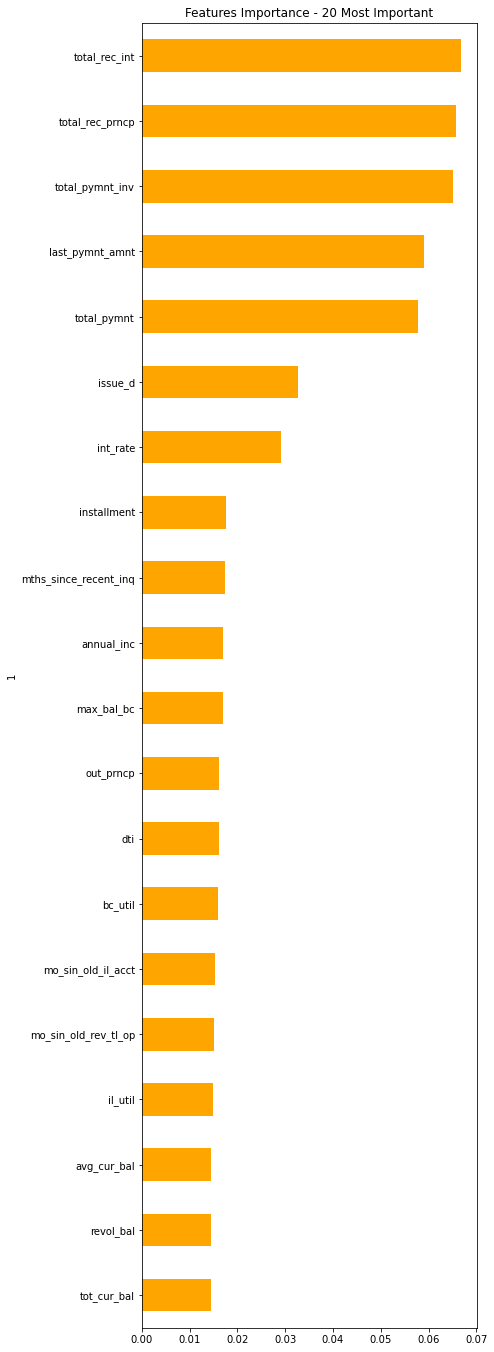

In [52]:
# Visualize the features by importance
BRF_importances_df = pd.DataFrame(BRF_sorted_20_most_important_list)
BRF_importances_df.set_index(BRF_importances_df[1], inplace=True)
BRF_importances_df.drop(columns=1, inplace=True)
BRF_importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
BRF_importances_sorted = BRF_importances_df.sort_values(by='Feature Importances')
BRF_importances_sorted.plot(
    kind='barh', 
    color='orange', 
    title= 'Features Importance - 20 Most Important', 
    legend=False, 
    figsize = (6,24)
)

### Easy Ensemble Classifier

In [53]:
# Train the Classifier
from imblearn.ensemble import EasyEnsembleClassifier

# Create a EasyEnsembleClassifier instance
EE_model = EasyEnsembleClassifier(n_estimators=500, random_state=1)

In [54]:
# Training data with the EasyEnsembleClassifier
EE_model = EE_model.fit(X_train, y_train)

# Making predictions using the testing data
EE_y_pred = EE_model.predict(X_test)

# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

EE_balanced_accuracy_score = balanced_accuracy_score(y_test, EE_y_pred)

print("Easy Ensemble Classifier Balanced Accuracy Score: {0:.6f}".format(
    EE_balanced_accuracy_score))

Easy Ensemble Classifier Balanced Accuracy Score: 0.926654


In [55]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

EE_confusion_array = confusion_matrix(y_test, EE_y_pred)

print("Easy Ensemble Classifier Confusion Matrix: \n")

# Converting the Confusion Matrix to a dataframe
EE_confusion_df = pd.DataFrame(
    EE_confusion_array, 
    index = ["High Risk [0] ", "Low Risk [1]"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying the Confusion Matrix
display(EE_confusion_df.head())

Easy Ensemble Classifier Confusion Matrix: 



,Predicted 0,Predicted 1
High Risk [0],79,8
Low Risk [1],937,16181


In [56]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print("Easy Ensemble Classifier Imbalanced Classification Report: \n")

target_names = ["High Risk", "Low Risk"]
print(classification_report_imbalanced(y_test, EE_y_pred, target_names = target_names))

Easy Ensemble Classifier Imbalanced Classification Report: 

                   pre       rec       spe        f1       geo       iba       sup

  High Risk       0.08      0.91      0.95      0.14      0.93      0.86        87
   Low Risk       1.00      0.95      0.91      0.97      0.93      0.86     17118

avg / total       0.99      0.95      0.91      0.97      0.93      0.86     17205



### Summary of the models  

In [57]:
print("Balanced Random Forrest Classifier Balanced Accuracy Score: {0:.6f}".format(
    BRF_balanced_accuracy_score))
print("Balanced Random Forrest Classifier Imbalanced Classification Report:")

target_names = ["High Risk", "Low Risk"]
print(classification_report_imbalanced(y_test, BRF_y_pred, target_names = target_names))

print("\n ------------------------------------------------------------------------- \n")
print("Easy Ensemble Classifier Balanced Accuracy Score: {0:.6f}".format(
    EE_balanced_accuracy_score))
print("Easy Ensemble Classifier Imbalanced Classification Report:")

target_names = ["High Risk", "Low Risk"]
print(classification_report_imbalanced(y_test, EE_y_pred, target_names = target_names))

Balanced Random Forrest Classifier Balanced Accuracy Score: 0.811026
Balanced Random Forrest Classifier Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

  High Risk       0.04      0.70      0.92      0.08      0.80      0.63        87
   Low Risk       1.00      0.92      0.70      0.96      0.80      0.66     17118

avg / total       0.99      0.92      0.70      0.95      0.80      0.66     17205


 ------------------------------------------------------------------------- 

Easy Ensemble Classifier Balanced Accuracy Score: 0.926654
Easy Ensemble Classifier Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

  High Risk       0.08      0.91      0.95      0.14      0.93      0.86        87
   Low Risk       1.00      0.95      0.91      0.97      0.93      0.86     17118

avg / total       0.99      0.95      0.91      0.97      0.93      0.86     172

### Final Questions

1. Which model had the best balanced accuracy score?

    Easy Ensemble Classifier provides the best balanced accuracy score: 0.926654   

2. Which model had the best recall score?

    Considering each of the Recall Scores with a model, the Easy Ensemble Classifier is better with High Risk [0] recall score of: 0.91 and Low Risk [1] recall score of: 0.95. If one to condsider only the average (weighted) recall score (with a 1.00) Balanced Random Forrest Classifier performs better. Since our focus is on High Risk lending Easy Ensemble Classifier having a High Risk Recall score of 0.91 as opposed to the 0.70 for the same in Balanced Random Forrest Classifier makes Easy Ensamble Classifier a better model.      

3. Which model had the best geometric mean score?

    Geometric mean score is higher (with a 0.93 for both High Risk and Low Risk) for the Easy Ensemble Classifier is much better than Balanced Random Forrest Classifier (with 0.80 for both High and Low Risk cases) 

4. What are the top three features?

    The top 3 features according their importance in descending order are "total_rec_int", "total_rec_prncp", and "total_pymnt_inv". These are among the 5 topfeatures disproporationately facotrs in for a lending loan being high risk or low risk.   